In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score,accuracy_score

from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt

X_PATH = 'tmp/X_InferSent_with_user_marker_empty0_aull'
Y_PATH = 'tmp/Y_InferSent_v2_aull'

X_TikTok_PATH = 'tmp/X_TikTok_with_user_marker_empty0_aull'
Y_TikTok_PATH = 'tmp/Y_TikTok_aull'

X_JOKER_PATH = 'tmp/X_JOKER_with_user_marker_empty0_aull'
Y_JOKER_PATH = 'tmp/Y_JOKER_aull'

X_IRIS_PATH = 'tmp/X_IRIS_with_user_marker_empty0_aull'
Y_IRIS_PATH = 'tmp/Y_IRIS_aull'

X_valid_chatbot_PATH = 'tmp/X_TikTok_JOKER_IRIS_chatbot_aull'
Y_valid_chatbot_PATH = 'tmp/Y_TikTok_JOKER_IRIS_chatbot_aull'

C:\Users\frizman04\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_next_batch(X,Y,batch_size,batch_indx) :
    '''
    Iterate over batches.
        return X_batch,y_bath,seq_length_inbatch
    
    '''
    left_bound = batch_indx*batch_size
    right_bound = (batch_indx + 1)*batch_size
    if right_bound > X.shape[0] :
        right_bound = X.shape[0]
    
    X_batch = X[left_bound:right_bound,:]
    Y_batch = Y[left_bound:right_bound,:]
    seq_length = get_seq_len(X_batch)
    return (X_batch,Y_batch,seq_length)

In [3]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.log_device_placement = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
#sess = tf.InteractiveSession(config=config)

sess = tf.InteractiveSession()

In [11]:
#sess.close()

In [4]:
loader = tf.train.import_meta_graph('model/lstm32d64_c_seql_paddzer_lr3_100_lr4_150.ckpt.meta')
loader.restore(sess,'model/lstm32d64_c_seql_paddzer_lr3_100_lr4_150.ckpt')

INFO:tensorflow:Restoring parameters from model/lstm32d64_c_seql_paddzer_lr3_100_lr4_150.ckpt


In [5]:
input_vect = tf.get_default_graph().get_tensor_by_name('input_vect:0')
input_y = tf.get_default_graph().get_tensor_by_name('input_y:0')
sequence_length = tf.get_default_graph().get_tensor_by_name('seq_length:0')

#init = tf.global_variables_initializer()
#sess.run(init)

logits = tf.get_default_graph().get_tensor_by_name('logits/Sigmoid:0')

# Проверка на соедененных данных

In [6]:
#load data
def get_seq_len(X) :
    return np.sum(X.sum(axis=2) != 0,axis=1)

X = np.load(open(X_valid_chatbot_PATH,'rb'))
Y = np.load(open(Y_valid_chatbot_PATH,'rb'))

In [7]:
batch_size = 128

In [8]:
def predict(sess,X,Y,batch_size, seq_limit = None):
    total_pred = []
    batch_cnt = X.shape[0] // batch_size + 1

    for batch_indx in range(batch_cnt) :
        X_train_batch,y_train_batch,seq_length = get_next_batch(X,Y,batch_size,batch_indx)    
        
        if not(seq_limit is None) :
            seq_length = np.where(seq_length > seq_limit,seq_limit,seq_length)
            
        pred = sess.run(logits, {input_vect : X_train_batch,
                                 input_y: y_train_batch,
                                 sequence_length:seq_length})
        total_pred += list(pred)

    total_pred = [list(pred) for pred in total_pred]
    total_pred = np.array(total_pred)
    return total_pred

total_pred = predict(sess,X,Y,batch_size)

In [9]:
acc = np.average((total_pred > 0.5) == Y)
auc = roc_auc_score(Y,total_pred)

print('with out l2')
print('On TikTok JOKER IRIS chatbot')
print()
print('AUC_ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

with out l2
On TikTok JOKER IRIS chatbot

AUC_ROC  : 0.8274601164414054
Accuracy : 0.7323284823284824 


In [10]:
acc = np.average((total_pred > 0.5) == Y)
auc = roc_auc_score(Y,total_pred)

print('On TikTok JOKER IRIS chatbot')
print()
print('AUC_ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

On TikTok JOKER IRIS chatbot

AUC_ROC  : 0.7282320702279123
Accuracy : 0.6678794178794178 


### На куске диалога

In [21]:
%%time
acc_list = []
auc_list = []

for dialog_leng in tqdm(range(X.shape[1])) :
    total_pred = predict(sess,X[:,0:dialog_leng,:],Y,batch_size,seq_limit = dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y)
    auc = roc_auc_score(Y,total_pred)
    
    acc_list.append(acc)
    auc_list.append(auc)

  5%|██████                                                                                                                   | 9/180 [00:21<06:39,  2.34s/it]

KeyboardInterrupt: 

In [22]:
plt.figure(figsize=(16,9))
plt.title('Accuracy on TikTok JOKER IRIS chatbot')
plt.xlabel('dialog length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0.2,0.8,0.025))
plt.plot(range(X.shape[1]),acc_list)
plt.savefig('img/accuracy_all_valid_chtbot_aull')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (180,) and (9,)

In [ ]:
plt.figure(figsize=(16,9))
plt.title('AUC on TikTok JOKER IRIS chatbot')
plt.xlabel('dialog length')
plt.ylabel('AUC ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.05))
plt.plot(range(X.shape[1]),auc_list)
plt.savefig('img/auc_all_valid_chtbot_aull')
plt.show()

# On Train dataset

In [153]:
X = np.load(open(X_PATH,'rb'))
Y = np.load(open(Y_PATH,'rb'))

In [155]:
total_pred = predict(sess,X,Y,batch_size)

In [60]:
#on train data
acc = np.average((total_pred > 0.5) == Y)
auc = roc_auc_score(Y,total_pred)


print('On train data')
print()
print('AUC_ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

On train data

AUC_ROC  : 0.9903951181218213
Accuracy : 0.9702790866255889 


# IRIS dataset

In [12]:
X_iris = np.load(open(X_IRIS_PATH,'rb'))
Y_iris = np.load(open(Y_IRIS_PATH,'rb'))

#X_iris = np.concatenate((X_iris,X_tiktok[0][np.newaxis,:,:]),axis=0)
#Y_iris = np.concatenate((Y_iris,Y_tiktok[0][np.newaxis,:]),axis=0)

total_pred = predict(sess,X_iris,Y_iris,batch_size)

In [ ]:
Y_iris.shape

In [13]:
total_pred = predict(sess,X_iris,Y_iris,batch_size)

In [14]:
acc = np.average((total_pred > 0.5) == Y_iris)
auc = roc_auc_score(Y_iris,total_pred)

print('With out l2  + aull')
print('On IRIS dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

With out l2  + aull
On IRIS dataset
AUC ROC  : 0.7784259851706876
Accuracy : 0.7085889570552147 


In [311]:
acc = np.average((total_pred > 0.5) == Y_iris)
auc = roc_auc_score(Y_iris,total_pred)

print('On IRIS dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

On IRIS dataset
AUC ROC  : 0.7453987730061349
Accuracy : 0.5 


### На части диалога 

In [315]:
%%time
acc_list = []
auc_list = []

for dialog_leng in tqdm(range(X_iris.shape[1])) :
    total_pred = predict(sess,X_iris[:,0:dialog_leng,:],Y_iris,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_iris)
    auc = roc_auc_score(Y_iris,total_pred)
    
    acc_list.append(acc)
    auc_list.append(auc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [02:22<00:00,  1.27it/s]


Wall time: 2min 22s


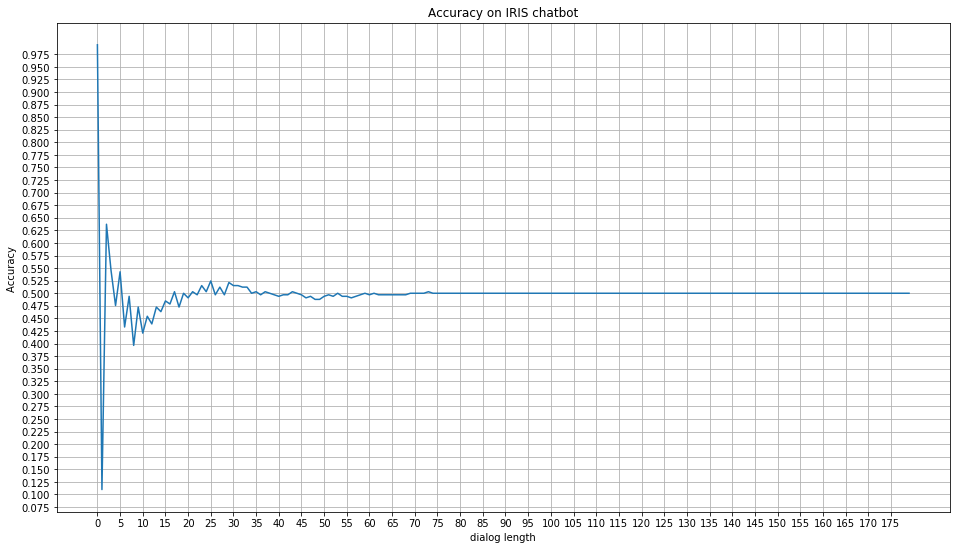

In [320]:
plt.figure(figsize=(16,9))
plt.title('Accuracy on IRIS chatbot')
plt.xlabel('dialog length')
plt.ylabel('Accuracy ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.025))
plt.plot(range(X_iris.shape[1]),acc_list)
plt.savefig('img/accuracy_IRIS_chtbot')
plt.show()

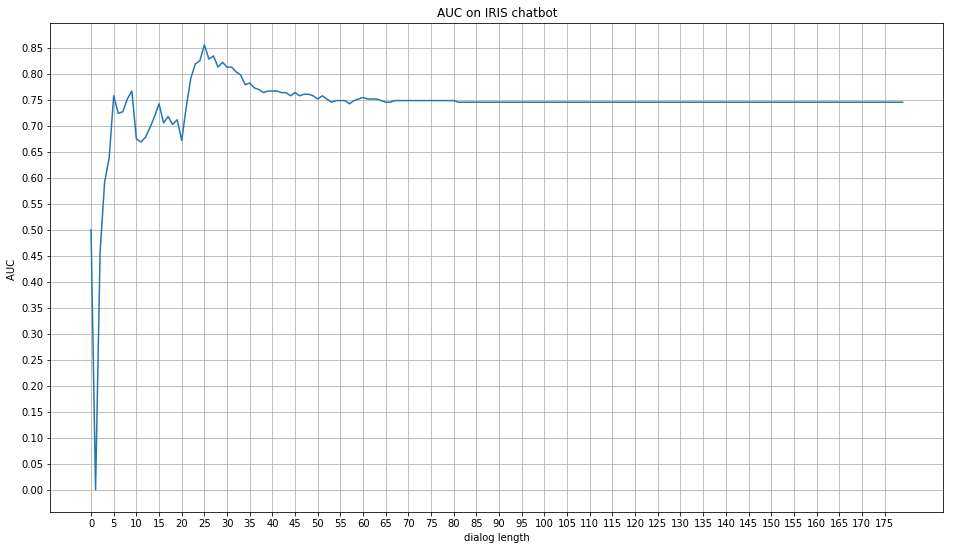

In [319]:
plt.figure(figsize=(16,9))
plt.title('AUC on IRIS chatbot')
plt.xlabel('dialog length')
plt.ylabel('AUC ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.05))
plt.plot(range(X_iris.shape[1]),auc_list)
plt.savefig('img/auc_IRIS_chtbot')
plt.show()

# JOKER dataset

In [15]:
X_joker = np.load(open(X_JOKER_PATH,'rb'))
Y_joker = np.load(open(Y_JOKER_PATH,'rb'))

In [216]:
X_joker = np.concatenate((X_joker,X_iris[0][np.newaxis,:,:]),axis=0)
Y_joker = np.concatenate((Y_joker,Y_iris[0][np.newaxis,:]),axis=0)

In [16]:
total_pred = predict(sess,X_joker,Y_joker,batch_size)

In [17]:
acc = np.average((total_pred > 0.5) == Y_joker)
auc = roc_auc_score(Y_joker,total_pred)

print('with out l2 + aull')
print('On Joker dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

with out l2 + aull
On Joker dataset
AUC ROC  : 0.7253667091836735
Accuracy : 0.6495535714285714 


In [221]:
acc = np.average((total_pred > 0.5) == Y_joker)
auc = roc_auc_score(Y_joker,total_pred)

print('On Joker dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

On Joker dataset
AUC ROC  : 0.9419642857142857
Accuracy : 0.6858407079646017 


In [324]:
%%time
acc_list = []
auc_list = []

for dialog_leng in tqdm(range(X_joker.shape[1])) :
    total_pred = predict(sess,X_joker[:,0:dialog_leng,:],Y_joker,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_joker)
    auc = roc_auc_score(Y_joker,total_pred)
    
    acc_list.append(acc)
    auc_list.append(auc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:42<00:00,  1.76it/s]


Wall time: 1min 42s


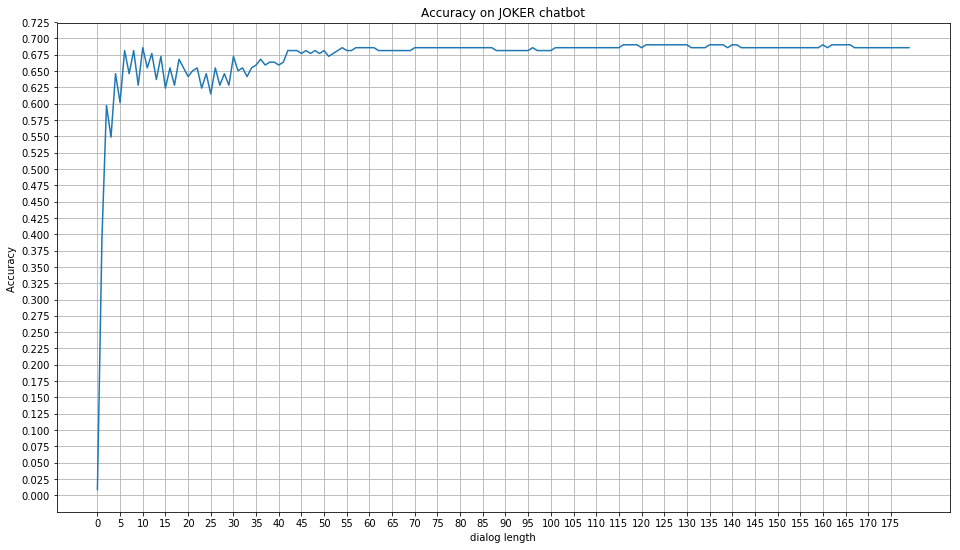

In [325]:
plt.figure(figsize=(16,9))
plt.title('Accuracy on JOKER chatbot')
plt.xlabel('dialog length')
plt.ylabel('Accuracy ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.025))
plt.plot(range(X_joker.shape[1]),acc_list)
plt.savefig('img/accuracy_JOKER_chtbot')
plt.show()

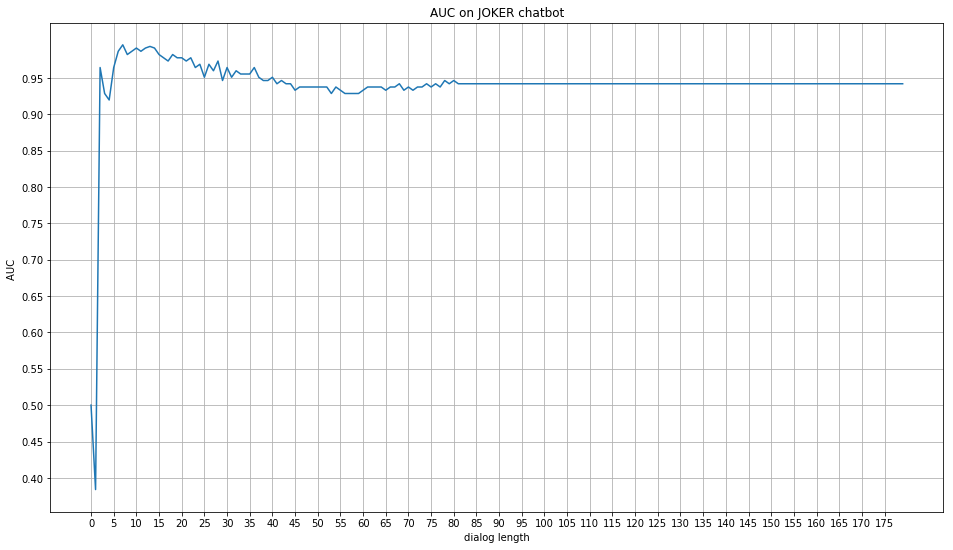

In [326]:
plt.figure(figsize=(16,9))
plt.title('AUC on JOKER chatbot')
plt.xlabel('dialog length')
plt.ylabel('AUC ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.05))
plt.plot(range(X_joker.shape[1]),auc_list)
plt.savefig('img/auc_JOKER_chtbot')
plt.show()

# TikTok dataset

In [18]:
X_tiktok = np.load(open(X_TikTok_PATH,'rb'))
Y_tiktok = np.load(open(Y_TikTok_PATH,'rb'))

In [223]:
X_tiktok = np.concatenate((X_tiktok,X_iris[0][np.newaxis,:,:]),axis=0)
Y_tiktok = np.concatenate((Y_tiktok,Y_iris[0][np.newaxis,:]),axis=0)

In [19]:
total_pred = predict(sess,X_tiktok,Y_tiktok,batch_size)

In [20]:
acc = np.average((total_pred > 0.5) == Y_tiktok)
auc = roc_auc_score(Y_tiktok,total_pred)

print('with out l2 + all')
print('On TikTok dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

with out l2 + all
On TikTok dataset
AUC ROC  : 0.91775850692808
Accuracy : 0.7961165048543689 


In [225]:
acc = np.average((total_pred > 0.5) == Y_tiktok)
auc = roc_auc_score(Y_tiktok,total_pred)

print('On TikTok dataset')
print('AUC ROC  : %s' % auc)
print('Accuracy : %s ' % acc)

On TikTok dataset
AUC ROC  : 0.9927184466019418
Accuracy : 0.9492753623188406 


In [327]:
%%time
acc_list = []
auc_list = []

for dialog_leng in tqdm(range(X_tiktok.shape[1])) :
    total_pred = predict(sess,X_tiktok[:,0:dialog_leng,:],Y_tiktok,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_tiktok)
    auc = roc_auc_score(Y_tiktok,total_pred)
    
    acc_list.append(acc)
    auc_list.append(auc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [02:53<00:00,  1.04it/s]


Wall time: 2min 53s


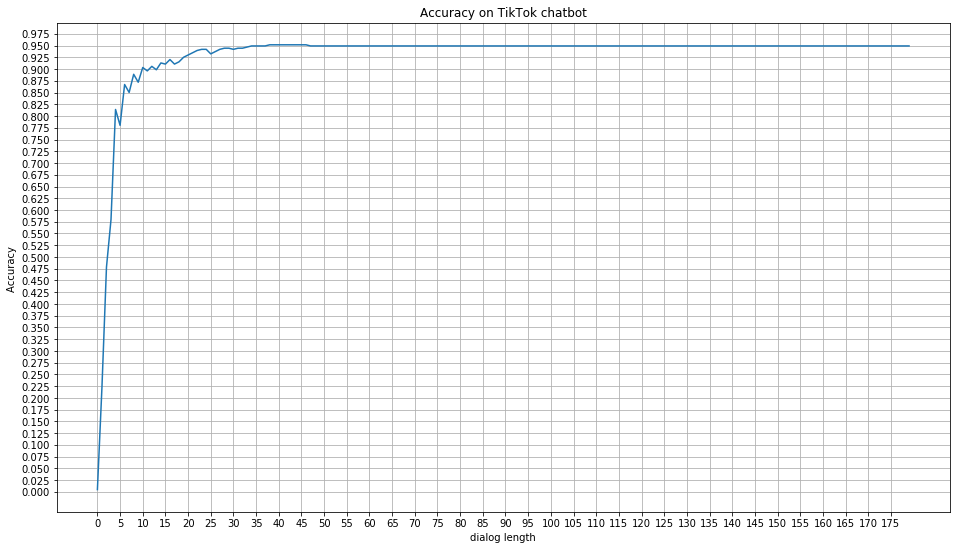

In [328]:
plt.figure(figsize=(16,9))
plt.title('Accuracy on TikTok chatbot')
plt.xlabel('dialog length')
plt.ylabel('Accuracy ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.025))
plt.plot(range(X_tiktok.shape[1]),acc_list)
plt.savefig('img/accuracy_TikTok_chtbot')
plt.show()

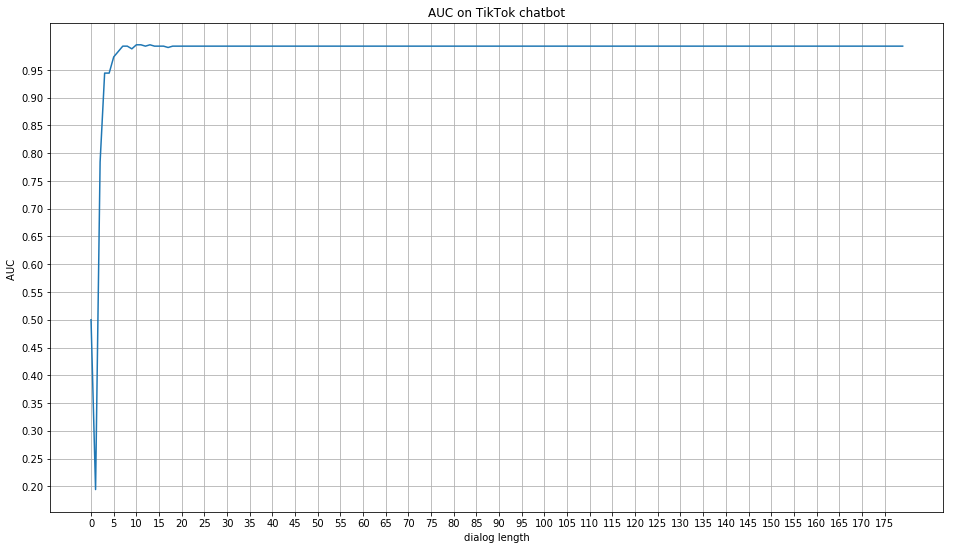

In [329]:
plt.figure(figsize=(16,9))
plt.title('AUC on TikTok chatbot')
plt.xlabel('dialog length')
plt.ylabel('AUC ')
plt.grid(True)
plt.xticks(np.arange(0,180,5))
plt.yticks(np.arange(0,1,0.05))
plt.plot(range(X_tiktok.shape[1]),auc_list)
plt.savefig('img/auc_TikTok_chtbot')
plt.show()

# А теперь получим это всё на одном графичке

In [8]:
X = np.load(open(X_valid_chatbot_PATH,'rb'))
Y = np.load(open(Y_valid_chatbot_PATH,'rb'))
print('WOCHAT was loaded')

X_iris = np.load(open(X_IRIS_PATH,'rb'))
Y_iris = np.load(open(Y_IRIS_PATH,'rb'))
print('IRIS was loaded')

X_joker = np.load(open(X_JOKER_PATH,'rb'))
Y_joker = np.load(open(Y_JOKER_PATH,'rb'))
print('JOKER was loaded')

X_tiktok = np.load(open(X_TikTok_PATH,'rb'))
Y_tiktok = np.load(open(Y_TikTok_PATH,'rb'))
print('Tiktok was loaded')

WOCHAT was loaded
IRIS was loaded
JOKER was loaded
Tiktok was loaded


In [9]:
X_iris = np.concatenate((X_iris,X_tiktok[0][np.newaxis,:,:]),axis=0)
Y_iris = np.concatenate((Y_iris,Y_tiktok[0][np.newaxis,:]),axis=0)

X_joker = np.concatenate((X_joker,X_iris[0][np.newaxis,:,:]),axis=0)
Y_joker = np.concatenate((Y_joker,Y_iris[0][np.newaxis,:]),axis=0)

X_tiktok = np.concatenate((X_tiktok,X_iris[0][np.newaxis,:,:]),axis=0)
Y_tiktok = np.concatenate((Y_tiktok,Y_iris[0][np.newaxis,:]),axis=0)

In [23]:
%%time
acc_list = []
auc_list = []

for dialog_leng in tqdm(range(X.shape[1])) :
    total_pred = predict(sess,X[:,0:dialog_leng,:],Y,batch_size,seq_limit = dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y)
    auc = roc_auc_score(Y,total_pred)
    
    acc_list.append(acc)
    auc_list.append(auc)


  6%|██████▋                                                                                                                 | 10/180 [00:03<01:06,  2.54it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\frizman04\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\frizman04\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\frizman04\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [13:07<00:00,  4.38s/it]


Wall time: 13min 7s


In [24]:
%%time
acc_iris_list = []
auc_iris_list = []

for dialog_leng in tqdm(range(X_iris.shape[1])) :
    total_pred = predict(sess,X_iris[:,0:dialog_leng,:],Y_iris,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_iris)
    auc = roc_auc_score(Y_iris,total_pred)
    
    acc_iris_list.append(acc)
    auc_iris_list.append(auc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [05:24<00:00,  1.80s/it]


Wall time: 5min 24s


In [25]:
%%time
acc_joker_list = []
auc_joker_list = []

for dialog_leng in tqdm(range(X_joker.shape[1])) :
    total_pred = predict(sess,X_joker[:,0:dialog_leng,:],Y_joker,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_joker)
    auc = roc_auc_score(Y_joker,total_pred)
    
    acc_joker_list.append(acc)
    auc_joker_list.append(auc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [03:50<00:00,  1.28s/it]


Wall time: 3min 50s


In [26]:
%%time
acc_tiktok_list = []
auc_tiktok_list = []

for dialog_leng in tqdm(range(X_tiktok.shape[1])) :
    total_pred = predict(sess,X_tiktok[:,0:dialog_leng,:],Y_tiktok,batch_size,dialog_leng)
    
    acc = np.average((total_pred > 0.5) == Y_tiktok)
    auc = roc_auc_score(Y_tiktok,total_pred)
    
    acc_tiktok_list.append(acc)
    auc_tiktok_list.append(auc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [05:47<00:00,  1.93s/it]


Wall time: 5min 47s


In [27]:
print('Work with my data nezno!')

Work with my data nezno!


In [28]:
matplotlib.rcParams.update({'font.size': 22})

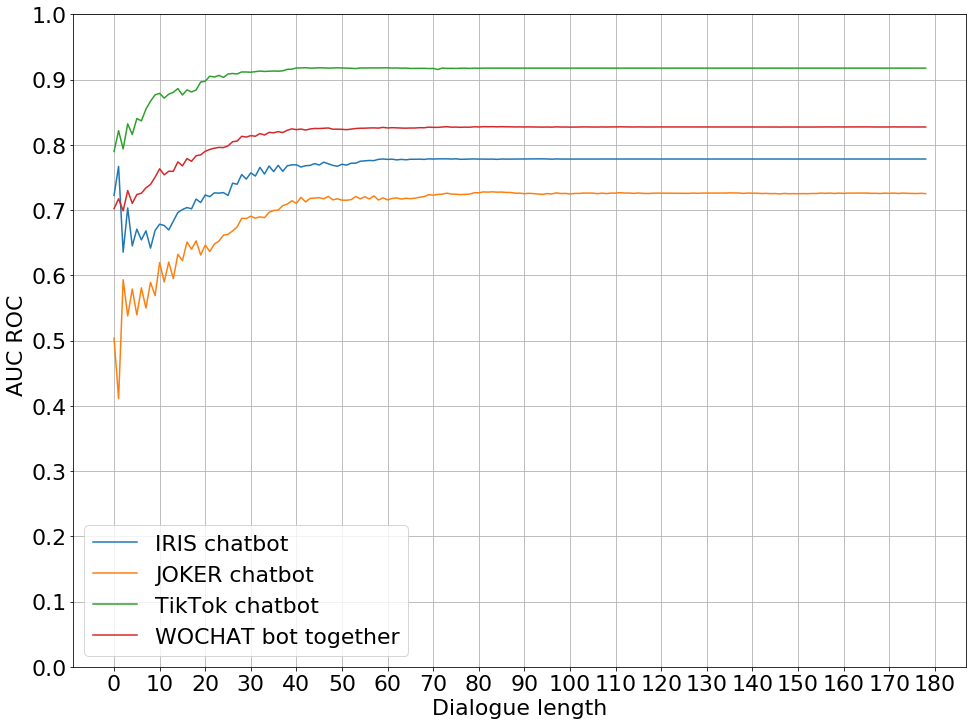

In [32]:
plt.figure(figsize=(16,12))

#plt.title('Impact dialogue length on AUC ROC score')
plt.xlabel('Dialogue length')
plt.ylabel('AUC ROC ')

plt.plot(auc_iris_list[1:], label = 'IRIS chatbot')
plt.plot(auc_joker_list[1:], label = 'JOKER chatbot')
plt.plot(auc_tiktok_list[1:], label = 'TikTok chatbot')
plt.plot(auc_list[1:], label = 'WOCHAT bot together')

plt.grid(True)
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,190,10))

plt.legend( loc=0, borderaxespad=0.5)
plt.savefig('img/auc_all_to_gather_aull.pdf',format='pdf')
plt.show()

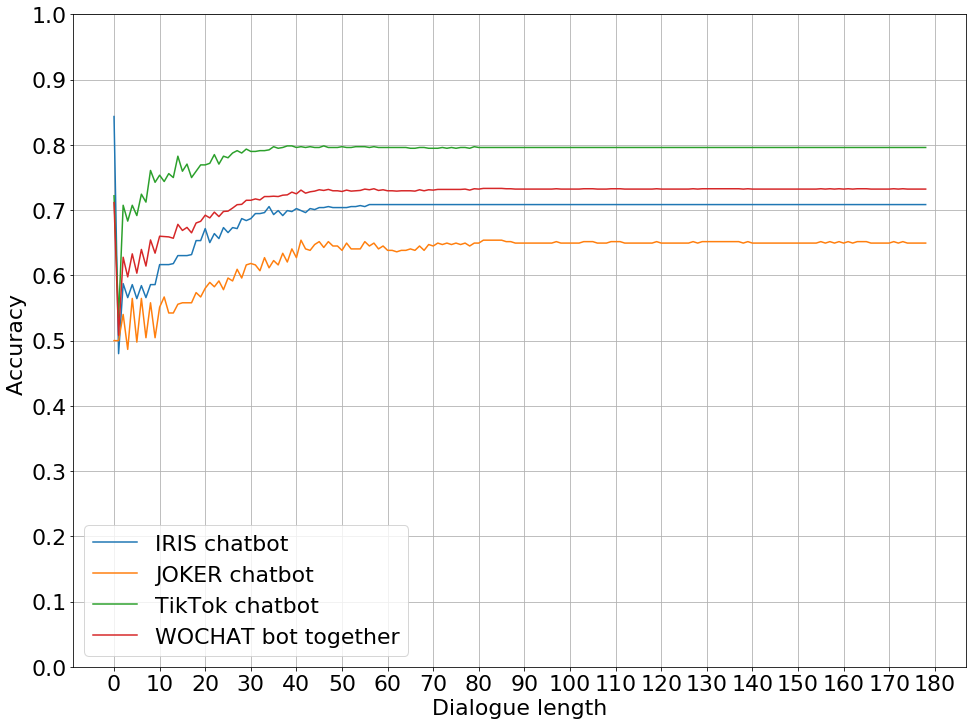

In [30]:
plt.figure(figsize=(16,12))

#plt.title('Impact dialogue length on Accuracy')
plt.xlabel('Dialogue length')
plt.ylabel('Accuracy ')

plt.plot(acc_iris_list[1:], label = 'IRIS chatbot')
plt.plot(acc_joker_list[1:], label = 'JOKER chatbot')
plt.plot(acc_tiktok_list[1:], label = 'TikTok chatbot')
plt.plot(acc_list[1:], label = 'WOCHAT bot together')

plt.grid(True)
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,190,10))

plt.legend(loc=0, borderaxespad=0.5)
plt.savefig('img/acc_all_to_gather_aull.pdf',format='pdf')
plt.show()